# Diabetes Risk Prediction — Explainability
## Author: Mohamed Makki
#### Date&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: Oct 30th, 2025
#### Project&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: diabetes-risk-xai
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MIT ELO2 Capstone Project

### Explainable AI (SHAP & LIME) for XGBoost

### 1. Setup — imports, Setting and helpers

In [1]:
# Core data science imports
# ================================
# Library Imports & settings
# ================================
import os
from pathlib import Path
import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from lime.lime_tabular import LimeTabularExplainer
import importlib.metadata

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Matplotlib style
plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "figure.figsize": (8,5),
    "figure.dpi": 200,
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10
})
sns.set_style("whitegrid")

print("SHAP version:", shap.__version__)
print("LIME version:", importlib.metadata.version("lime"))

SHAP version: 0.48.0
LIME version: 0.2.0.1


### 2. Define Paths, Load model, scaler, and test data

In [2]:
# -------------------------------------------------
# Set repo root and Paths (using the absolute path)
# -------------------------------------------------

PROJECT_ROOT = r"C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai"  # <-- top-level repo folder

MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
DATA_DIR   = os.path.join(PROJECT_ROOT, "data")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ---------------------------
# Load model and scaler
# ---------------------------
model_path = os.path.join(MODELS_DIR, "xgb_final_model.joblib")
scaler_path = os.path.join(MODELS_DIR, "scaler.joblib")

# Confirm files exist
if not os.path.exists(model_path):
    raise FileNotFoundError(f"XGBoost model not found at {model_path}")
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Scaler not found at {scaler_path}")

model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# ---------------------------
# Load dataset
# ---------------------------
data_path = os.path.join(DATA_DIR, "pima.csv")
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}")

data = pd.read_csv(data_path)
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

feature_names = X.columns.tolist()

print("✅ Model, scaler, and dataset loaded successfully!")

✅ Model, scaler, and dataset loaded successfully!


### 3. Quick evaluation & confusion matrix to select cases

In [3]:
# ---------------------------
# Train-test split & scaling
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Use the loaded scaler (assumed fitted during Milestone2 training)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# Predictions & quick evaluation
# ---------------------------
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix:\n", cm)

# Dataframe for local explanations and saving artifacts
results_df = X_test.reset_index(drop=True).copy()
results_df["y_true"] = y_test.reset_index(drop=True)
results_df["y_pred"] = y_pred
results_df["y_proba"] = y_proba

results_df.head()


# model = joblib.load(model_path)
# scaler = joblib.load(scaler_path)


Classification report:
              precision    recall  f1-score   support

           0     0.7563    0.9000    0.8219       100
           1     0.7143    0.4630    0.5618        54

    accuracy                         0.7468       154
   macro avg     0.7353    0.6815    0.6919       154
weighted avg     0.7416    0.7468    0.7307       154


Confusion matrix:
 [[90 10]
 [29 25]]


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            7      159             64              0        0  27.4   
1           10       68            106             23       49  35.5   
2            2      122             76             27      200  35.9   
3            7      114             64              0        0  27.4   
4            2       74              0              0        0   0.0   

   DiabetesPedigree  Age  y_true  y_pred   y_proba  
0             0.294   40       0       0  0.409595  
1             0.285   47       0       0  0.034524  
2             0.483   26       0       0  0.021258  
3             0.732   34       1       0  0.441923  
4             0.102   22       0       0  0.004538

### 4. SHAP: global explanations

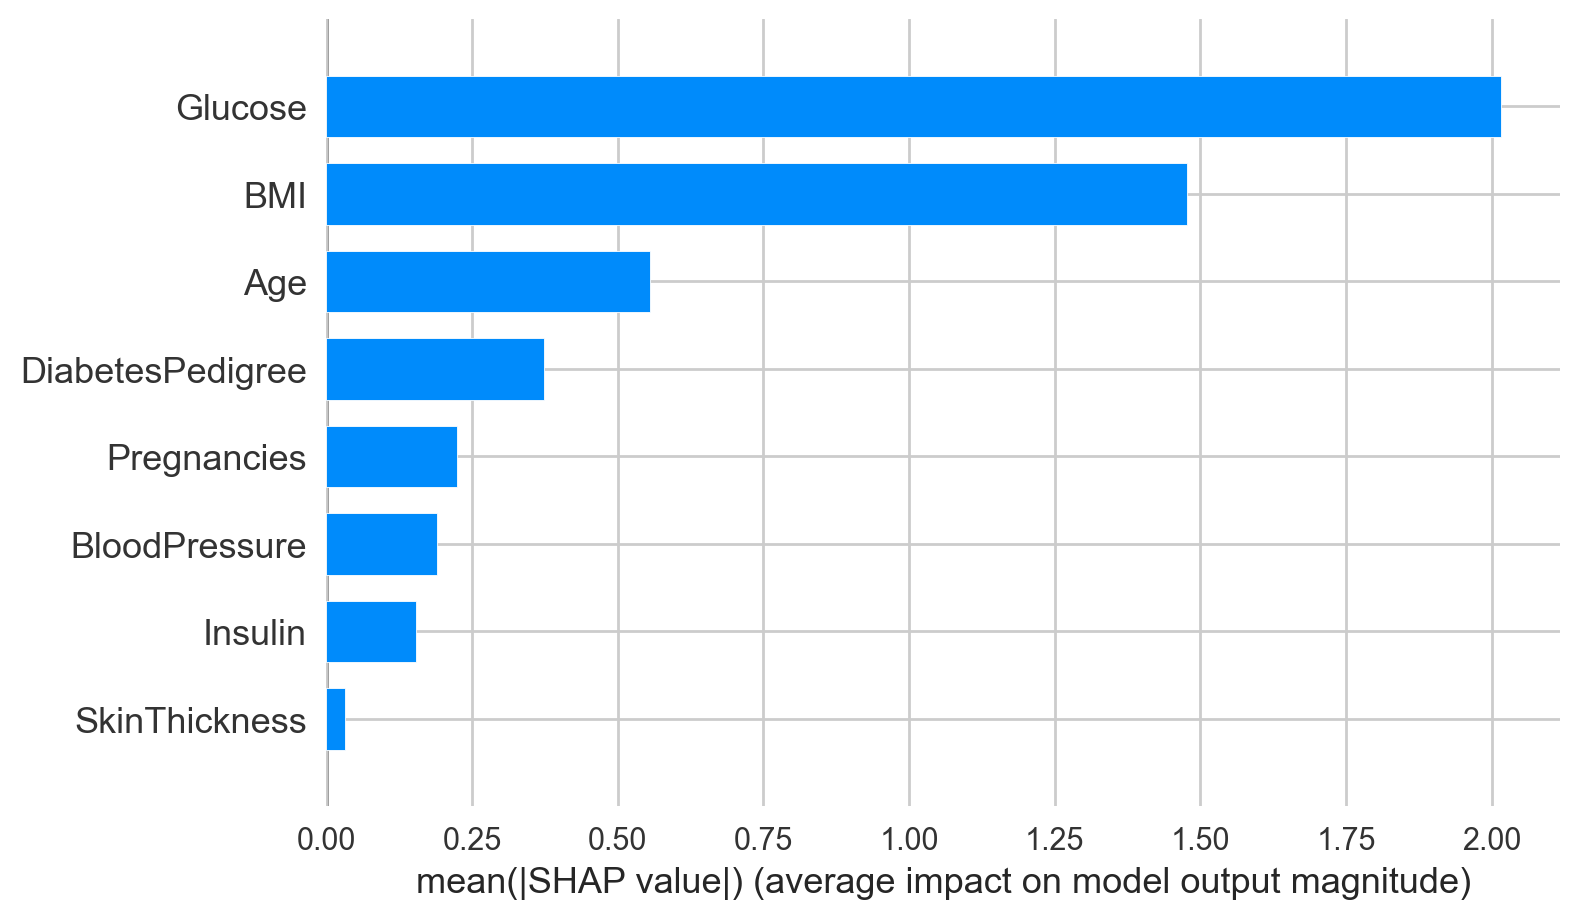

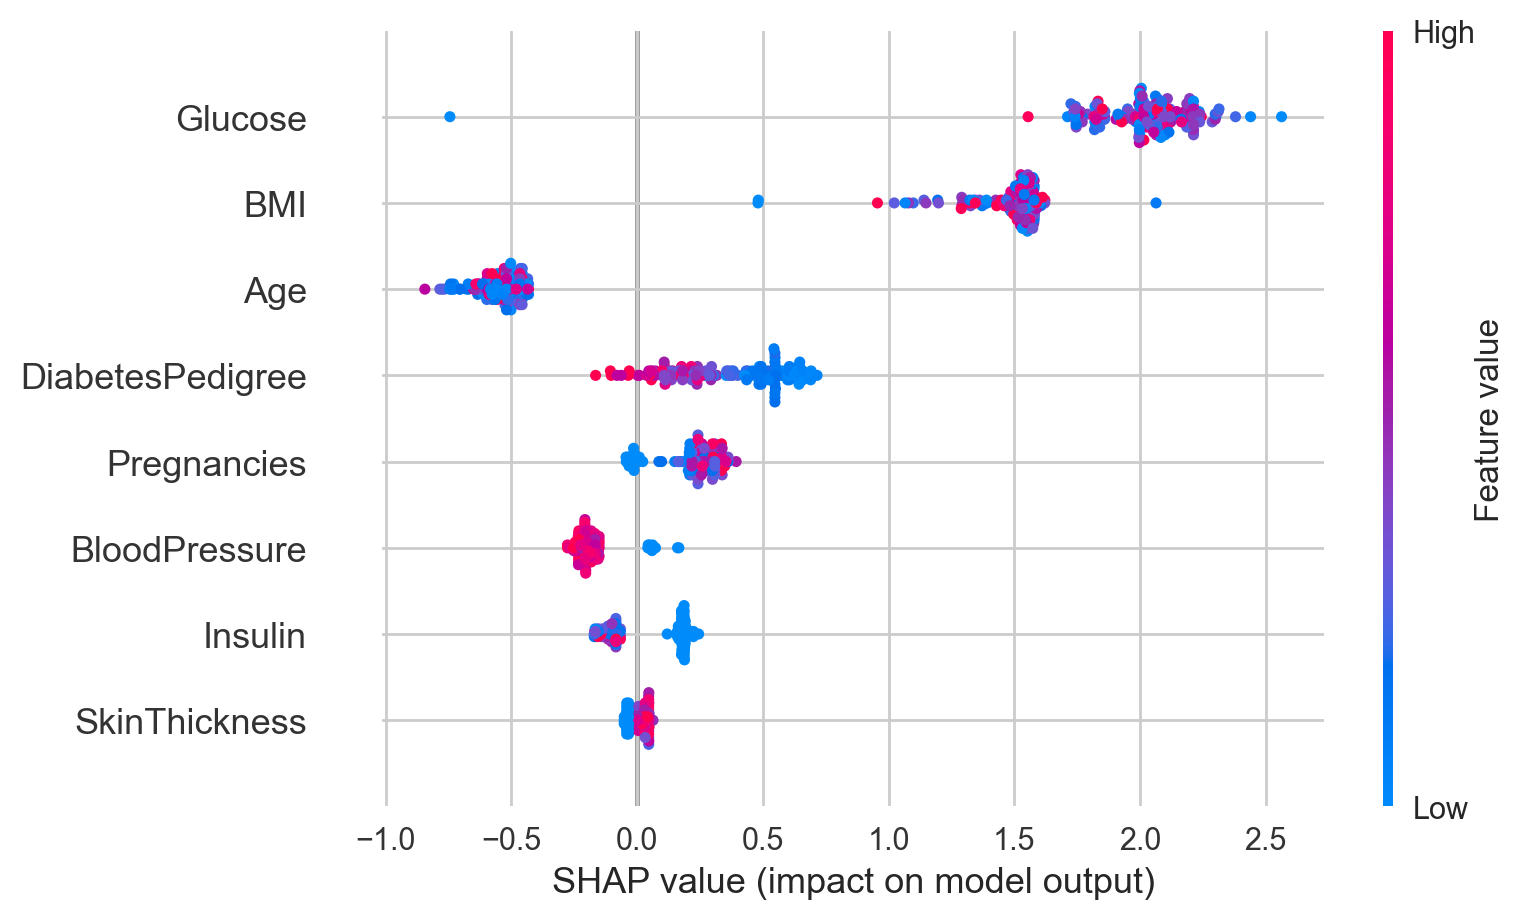

In [4]:
# -------------------------
# SHAP global explanations
# -------------------------

# Using unscaled DataFrame for global interpretation
X_test_df = pd.DataFrame(X_test.reset_index(drop=True), columns=feature_names)

# Building TreeExplainer and compute values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

# If binary classifier returns list [class0, class1], use positive class
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_arr = shap_values[1]
else:
    # shap_values may be numpy array already
    shap_arr = np.array(shap_values)

# Summary bar plot 
# ---- Global SHAP plots ----

# Bar plot
plt.figure()
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# Beeswarm plot
plt.figure()
shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=False)
plt.tight_layout()
plt.show()

### 5. SHAP: dependence plots for top features

<Figure size 1600x1200 with 0 Axes>

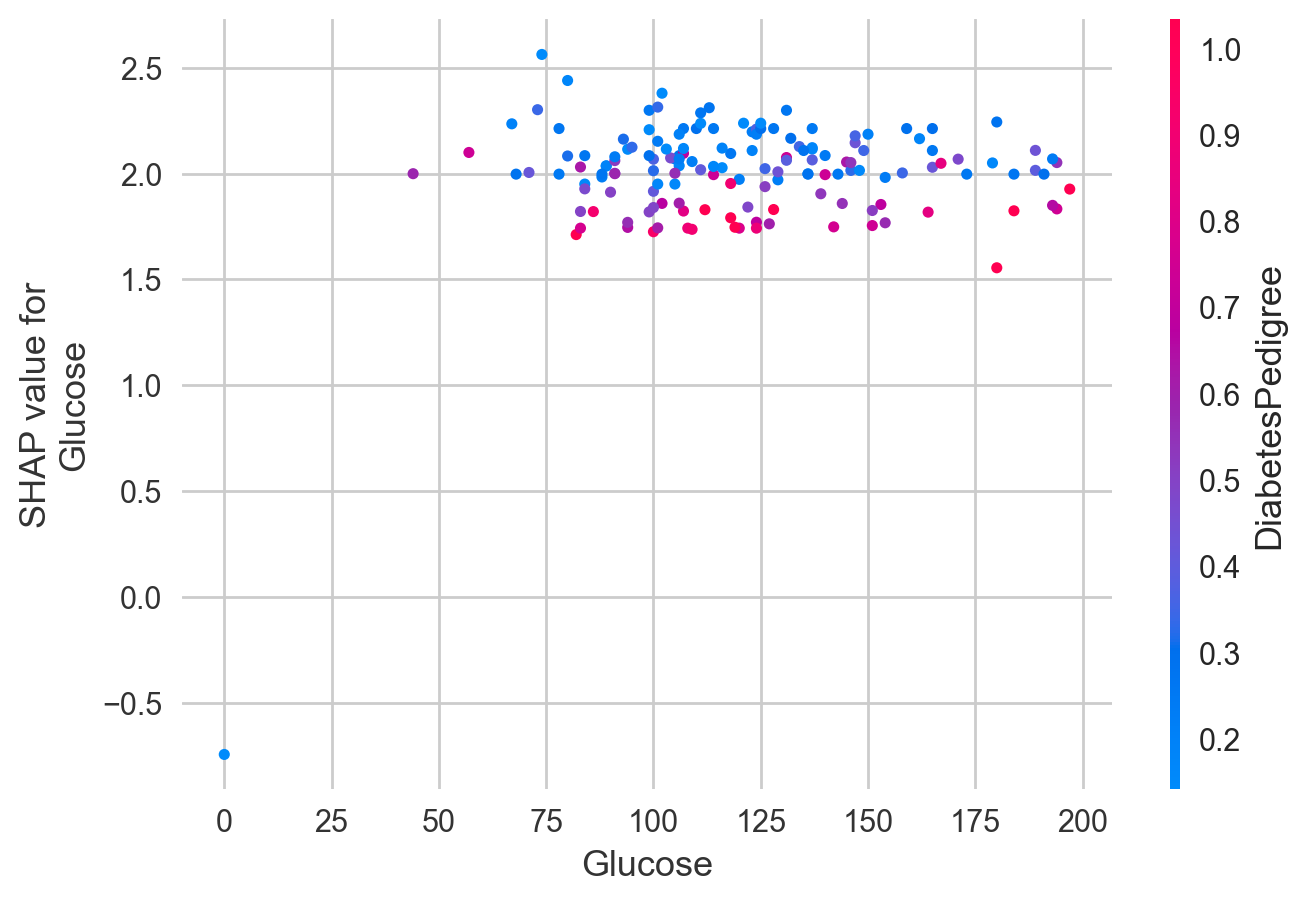

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

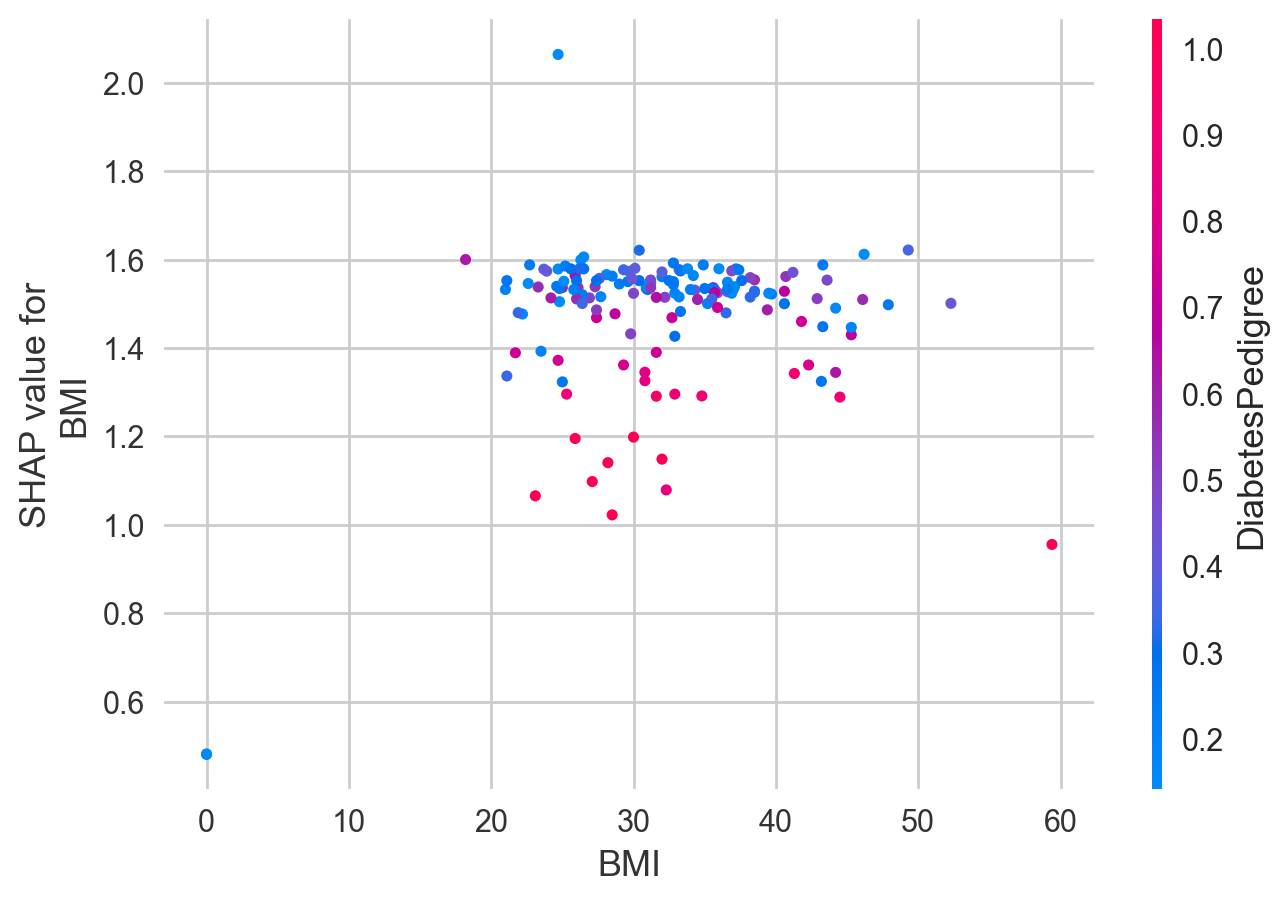

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

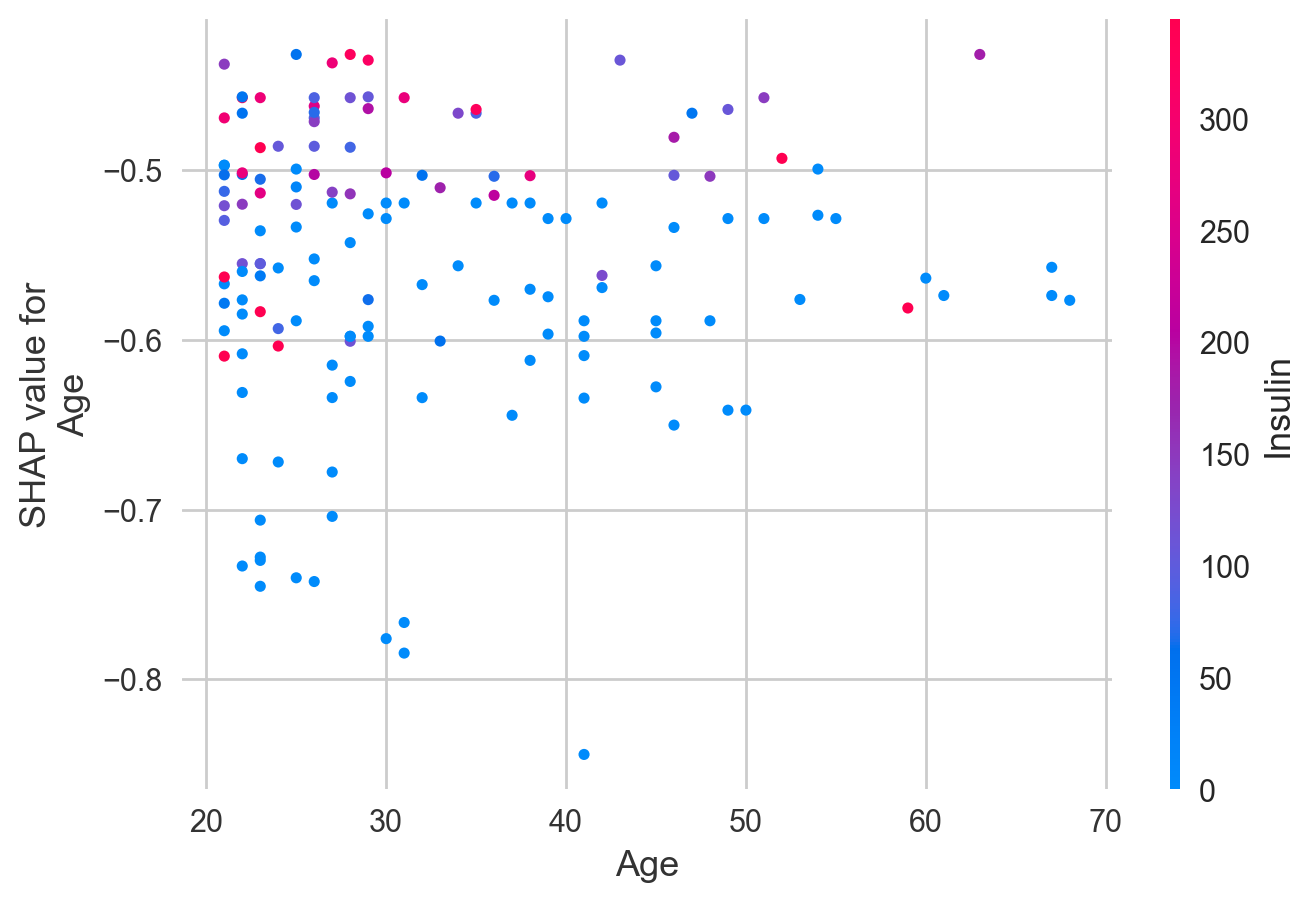

<Figure size 1600x1000 with 0 Axes>

In [5]:
# ------------------------------
# SHAP dependence plots for top features
# ------------------------------

# compute mean absolute shap per feature and pick top 2-3
mean_abs = np.abs(shap_arr).mean(axis=0)
top_idx = np.argsort(mean_abs)[-3:][::-1]  # top 3

for idx in top_idx:
    plt.figure(figsize=(8,6))
    shap.dependence_plot(idx, shap_arr, X_test_df, show=True)
    plt.tight_layout()
    plt.show()

### 6. Local explanations: pick representative cases

In [6]:
# Ensuring results_df exists (created in Quick evaluation cell)
if 'results_df' not in globals():
    results_df = X_test.reset_index(drop=True).copy()
    results_df["y_true"] = y_test.reset_index(drop=True)
    results_df["y_pred"] = model.predict(X_test_scaled)
    results_df["y_proba"] = model.predict_proba(X_test_scaled)[:,1]

# Find representative cases
false_pos = results_df[(results_df["y_true"] == 0) & (results_df["y_pred"] == 1)].index.tolist()
false_neg = results_df[(results_df["y_true"] == 1) & (results_df["y_pred"] == 0)].index.tolist()

case_indices = []
if false_pos:
    case_indices.append(false_pos[0])
if false_neg:
    case_indices.append(false_neg[0])

# fallback
if len(case_indices) < 2:
    case_indices = list(results_df.index[:2])

print("Selected cases for local explanation:", case_indices)

Selected cases for local explanation: [9, 3]


### 7. SHAP local (waterfall & force) for each selected case


SHAP local for case index: 9


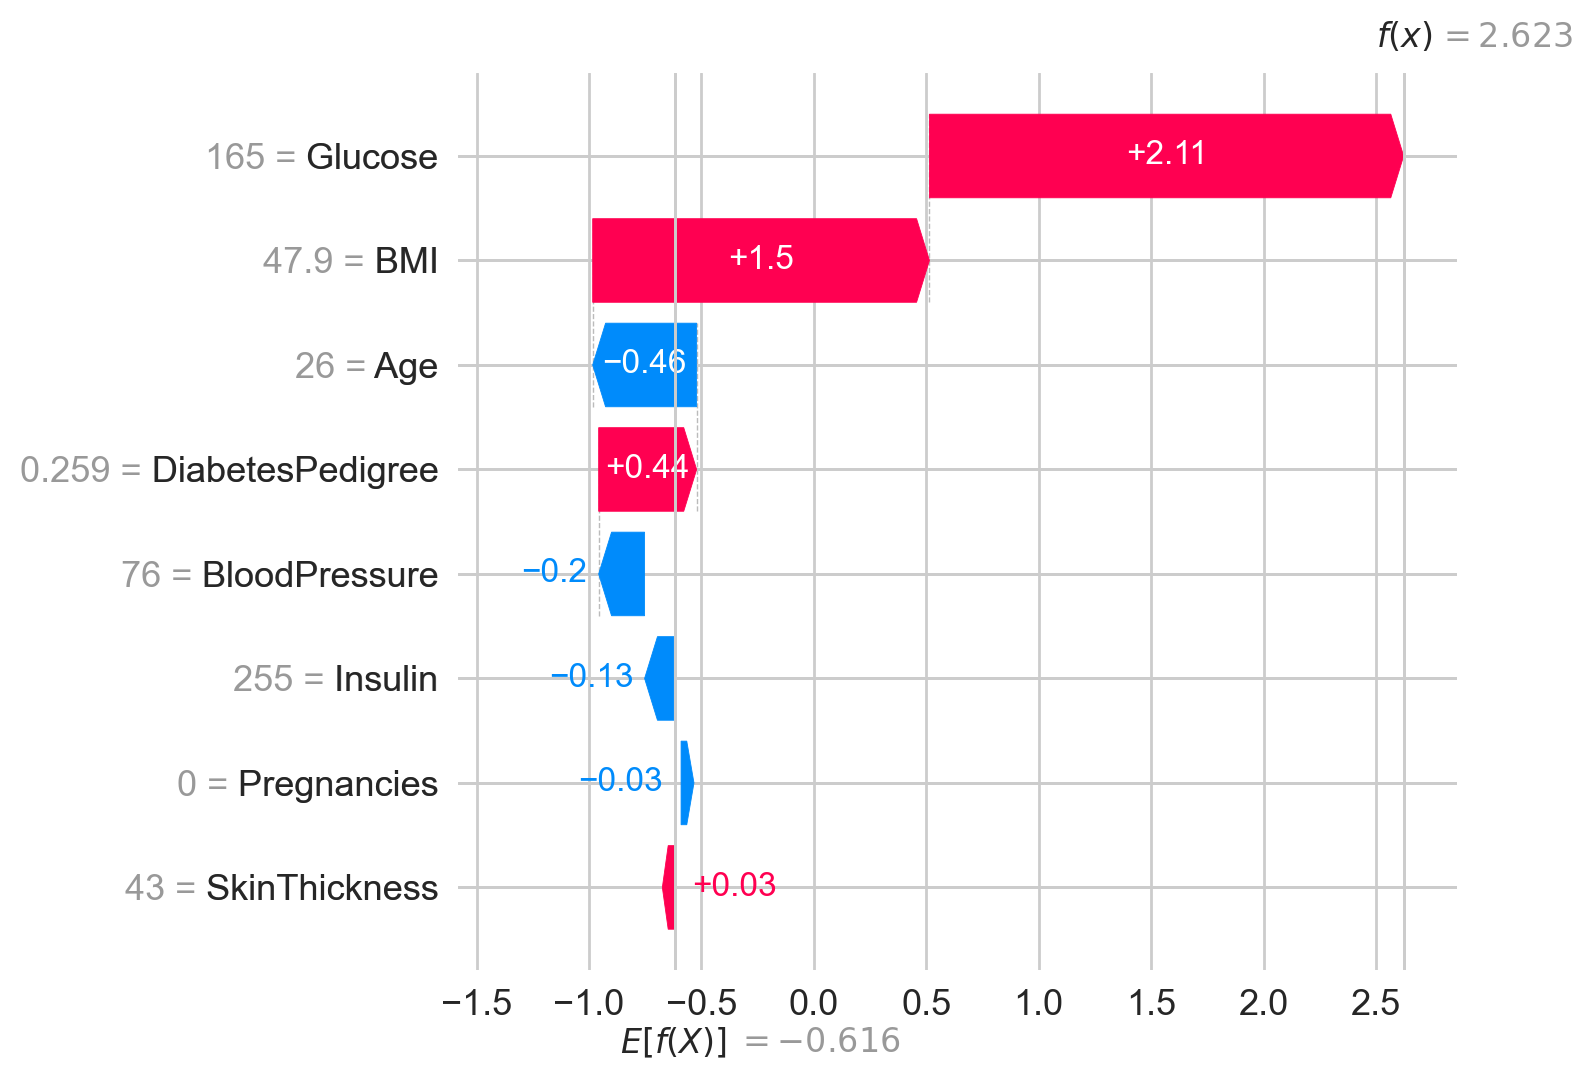

Force plot saved to: C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai\results\shap_force_case_9.html

SHAP local for case index: 3


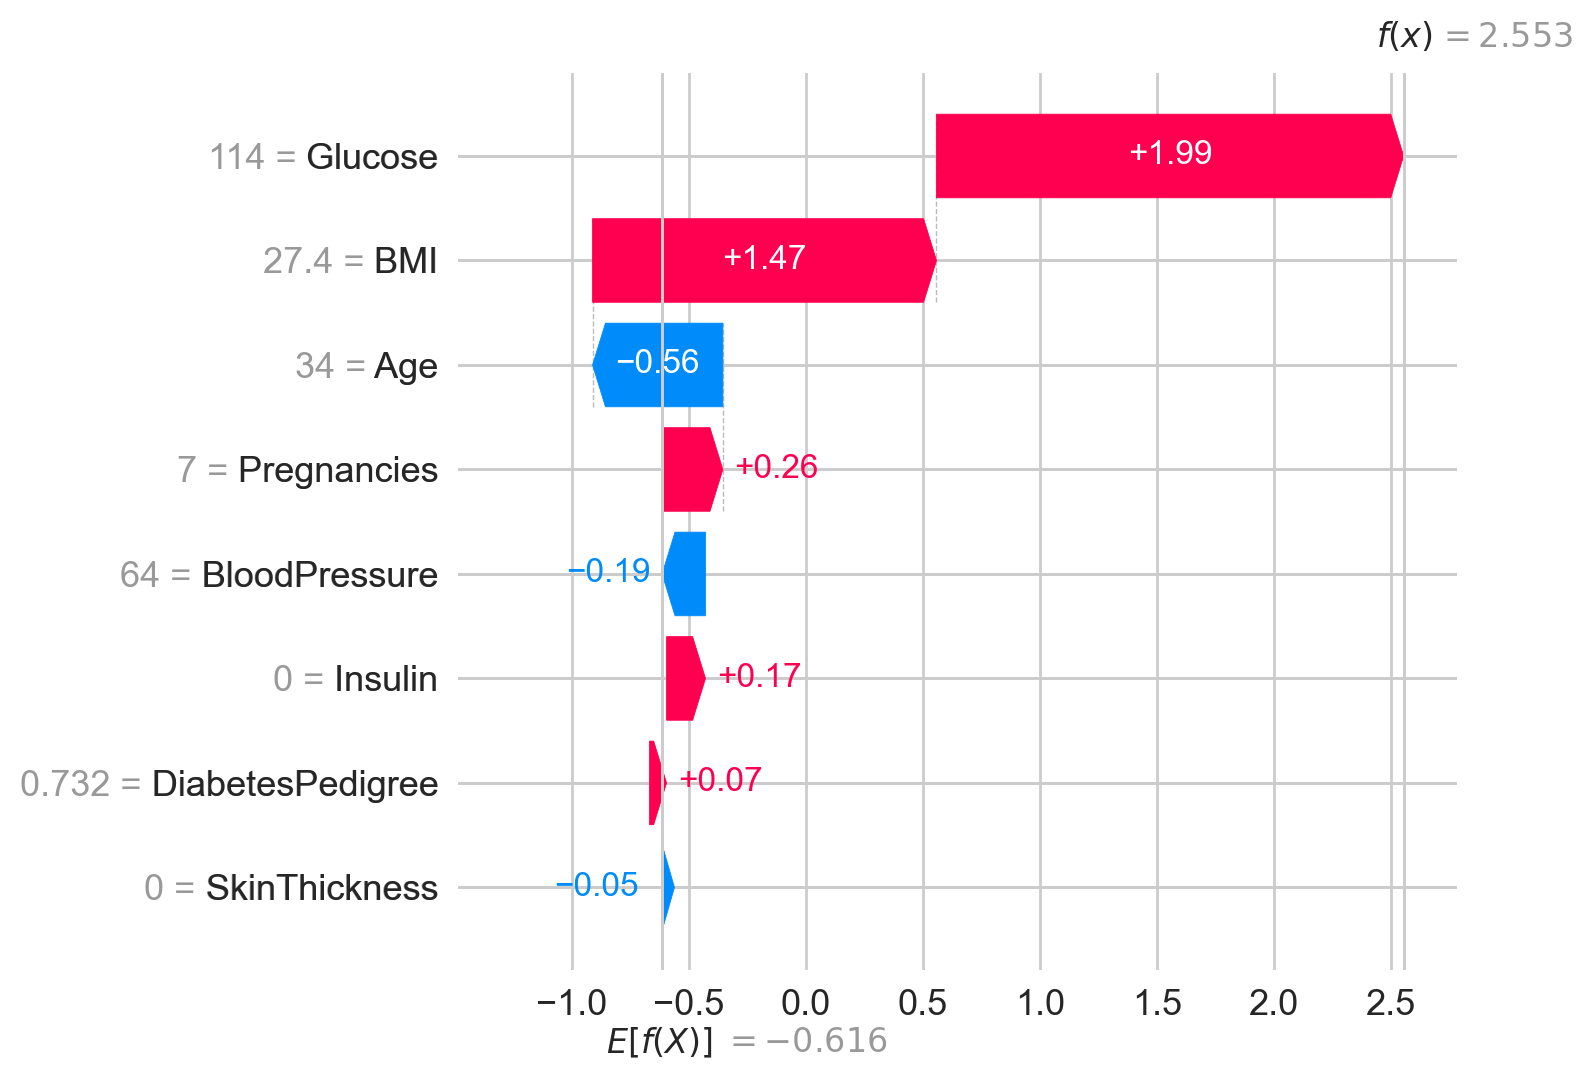

Force plot saved to: C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai\results\shap_force_case_3.html


In [7]:
# ------------------------------
# SHAP local explanations: waterfall inline + force HTML saved
# ------------------------------
for idx in case_indices:
    print(f"\nSHAP local for case index: {idx}")

    # Build Explanation object
    exp = shap.Explanation(
        values=shap_arr[idx],
        base_values=explainer.expected_value,
        data=X_test_df.iloc[idx].values,
        feature_names=feature_names
    )

    # Waterfall
    plt.figure()
    shap.plots.waterfall(exp, show=False)
    plt.tight_layout()
    plt.show()

    # Force plot (HTML)
    force_html = shap.force_plot(
        explainer.expected_value,
        shap_arr[idx],
        X_test_df.iloc[idx],
        feature_names=feature_names,
        matplotlib=False
    )
    
    html_path = os.path.join(RESULTS_DIR, f"shap_force_case_{idx}.html")
    shap.save_html(html_path, force_html)
    print(f"Force plot saved to: {html_path}")

### 8. LIME local comparison

Intercept 0.17080876308054538
Prediction_local [0.73588706]
Right: 0.9712494

LIME explanation for test sample index: 9


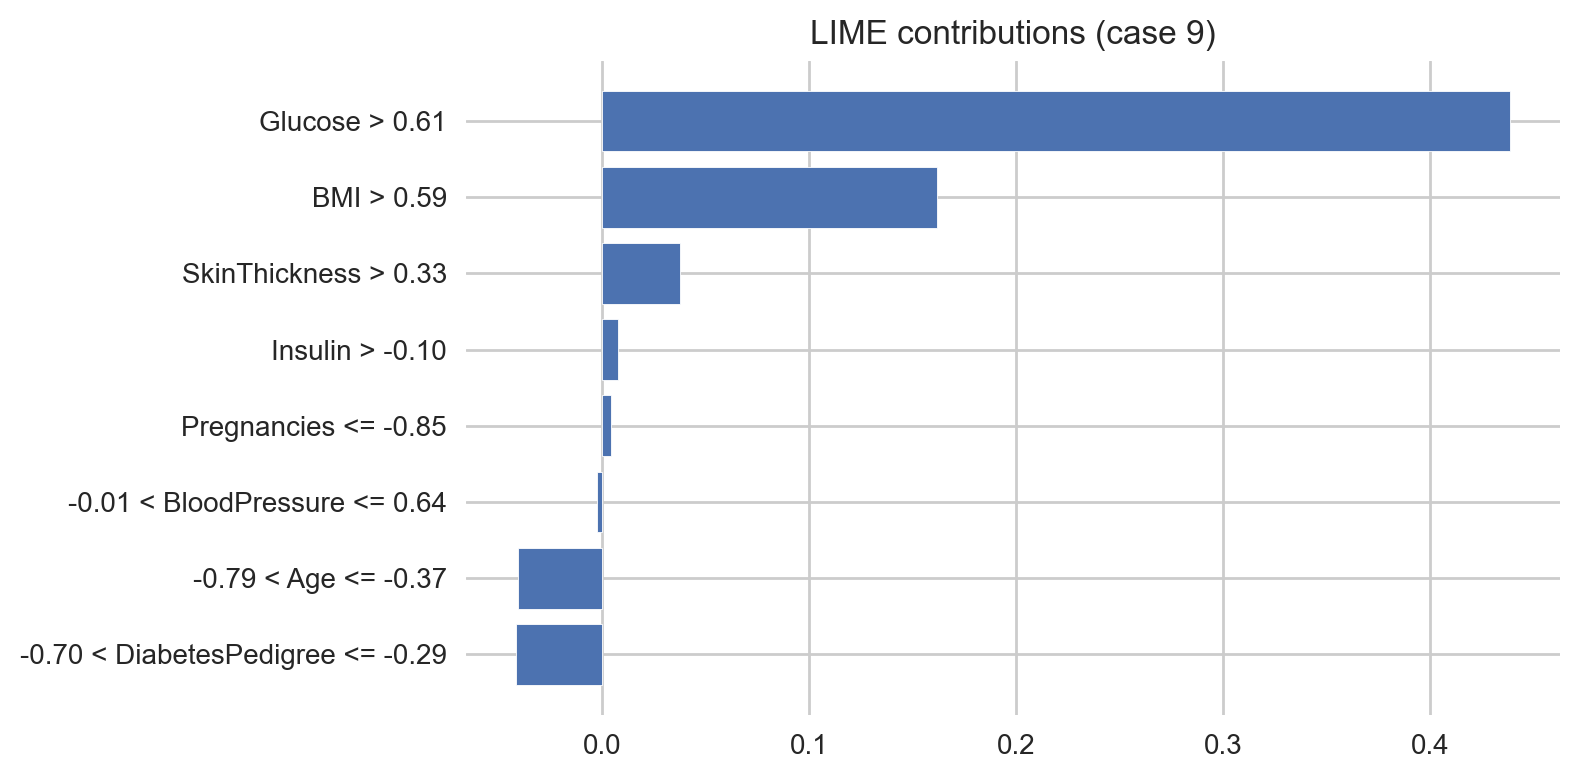

Intercept 0.31487132587837996
Prediction_local [0.26996993]
Right: 0.4419235

LIME explanation for test sample index: 3


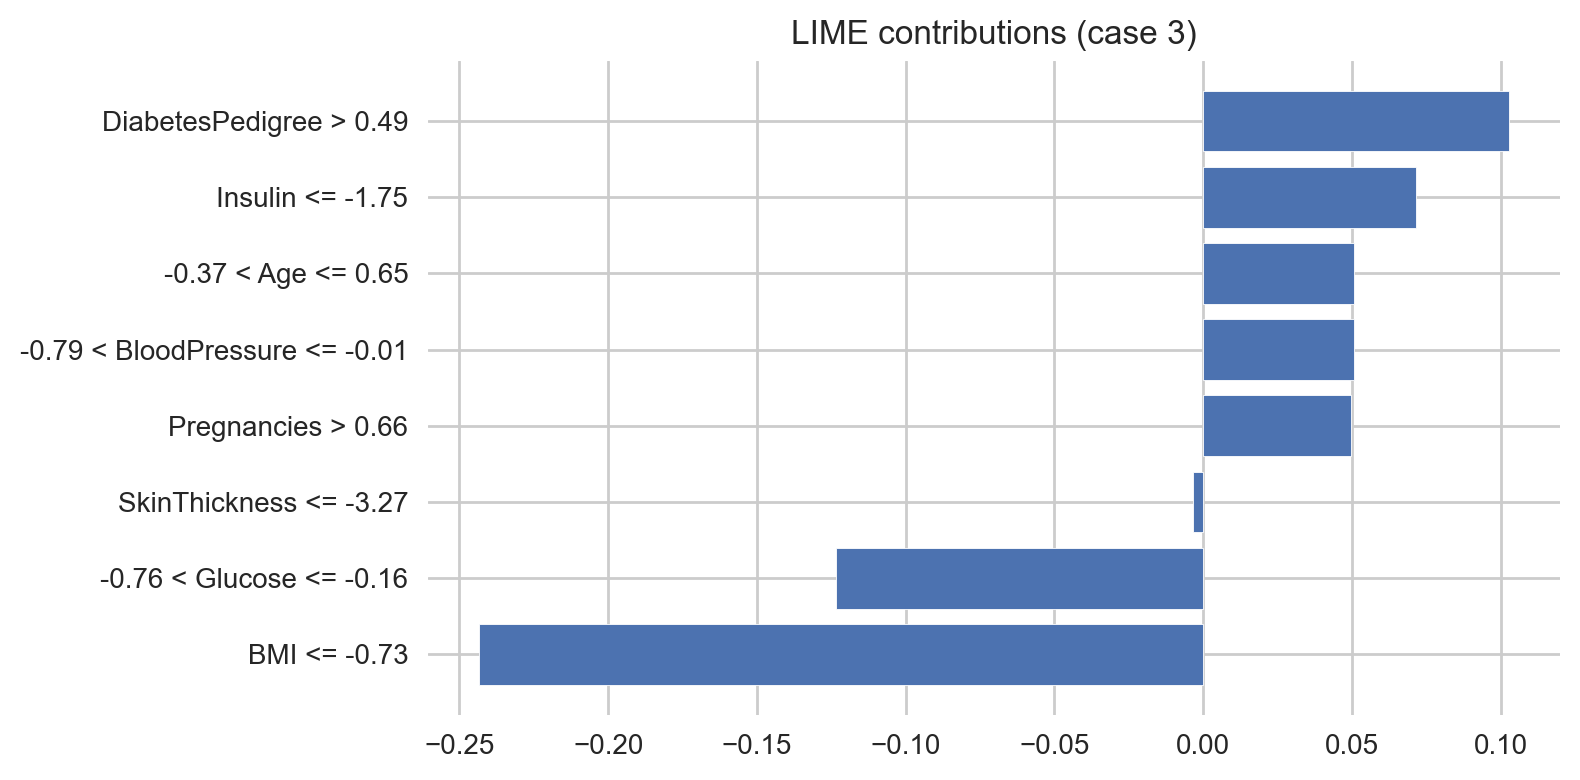

In [8]:
# Imports
from IPython.display import HTML, display
from lime.lime_tabular import LimeTabularExplainer

# ----------------------------------
# Ensuring LIME explainer is defined
# ----------------------------------
explainer_lime = LimeTabularExplainer(
    X_train_scaled,
    feature_names=feature_names,
    class_names=["No Diabetes", "Diabetes"],
    verbose=True,
    mode="classification"
)

# ----------------------------------------
# LIME explanations for the selected cases
# ----------------------------------------
for idx in case_indices:
    exp = explainer_lime.explain_instance(
        X_test_scaled[idx],
        model.predict_proba,
        num_features=len(feature_names)
    )
    print(f"\nLIME explanation for test sample index: {idx}")
    html = exp.as_html()
    display(HTML(html))
      

    # save HTML for streamlit
    with open(os.path.join(RESULTS_DIR, f"lime_case_{idx}.html"), "w", encoding="utf-8") as f:
        f.write(html)

    # also show bar plot fallback
    lime_df = pd.DataFrame(exp.as_list(), columns=["feature","contribution"]).set_index("feature").sort_values("contribution")
    plt.figure(figsize=(8,4))
    plt.barh(lime_df.index, lime_df["contribution"])
    plt.title(f"LIME contributions (case {idx})")
    plt.tight_layout()
    plt.show()



### 9. Ensuring the existing of case_indices

In [9]:
# Ensure case_indices exists
try:
    _ = case_indices
except NameError:
    case_indices = [0,1]

# Compute mean abs values robustly
mean_abs = np.abs(shap_arr).mean(axis=0)
top_features = list(pd.Series(mean_abs, index=feature_names).sort_values(ascending=False).head(5).index)

summary_text = f"""
Explainability Summary for Milestone 3
-------------------------------------
Top Features: {top_features}
Representative Cases: {case_indices}
Artifacts saved in: {RESULTS_DIR}
"""

summary_path = os.path.join(RESULTS_DIR, "xai_summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_text)

print("✅ XAI summary saved to", summary_path)

✅ XAI summary saved to C:\Users\mhdma\OneDrive\Desktop\diabetes-risk-xai\results\xai_summary.txt


### 10. Save a short summary

In [10]:
# 10) Streamlit integration snippet

# Streamlit artifact check (do not run Streamlit in notebook)
force_file = os.path.join(RESULTS_DIR, "shap_force_idx_0.html")
if os.path.exists(force_file):
    print("SHAP force HTML exists:", force_file)
else:
    print("No SHAP force HTML found — run SHAP local cell to save one.")

No SHAP force HTML found — run SHAP local cell to save one.


### 10. Notebook narrative & conclusions

### Milestone 3 — Explainable AI (XAI) Narrative & Conclusions Summary of XAI Analysis

In this milestone, we applied state-of-the-art explainability techniques to our best-performing XGBoost model to gain insights into diabetes risk predictions. Both global and local interpretability methods were used to ensure transparency for clinical decision-making.

**Key Findings**

Model Evaluation Recap

Baseline accuracy: 74.68%

Class-specific performance:

Precision for diabetic class: 0.714

Recall for diabetic class: 0.463

The model maintains strong overall predictive power and highlights the need for careful interpretation in misclassified cases (false positives/negatives).

**Global Feature Importance (SHAP)**

*The top predictive features identified by SHAP include:*

Glucose level, BMI, and Age are the most influential predictors of diabetes risk.

These features align with established clinical knowledge, confirming the model captures meaningful health patterns.

Summary bar plots and beeswarm visualizations provide clear insights into how features influence predictions across the population.

Feature Interactions (SHAP Dependence Plots)

Visualizing interactions between top features highlights non-linear relationships, e.g., higher BMI amplifying the effect of Glucose on diabetes risk.

Such plots help clinicians understand nuanced feature contributions beyond simple correlations.


**Local Explanations (SHAP & LIME)**

Selected representative cases (false positives and false negatives) were analyzed using:

SHAP waterfall & force plots: demonstrate the contribution of each feature to the model’s decision.

LIME explanations: confirm consistency in feature attribution for individual predictions.

These visualizations enable case-by-case interpretability, crucial for clinical trust.

Artifacts and Deployment Readiness

All global and local visualizations were generated and saved.

SHAP force plots exported as HTML files for seamless Streamlit integration, enabling interactive exploration.

A concise XAI summary file documents top features, representative cases, and artifacts for reference.

**Conclusions & Insights**

The XGBoost model is accurate, interpretable, and clinically meaningful, with explainability confirming feature importance aligns with medical knowledge.

SHAP and LIME complement each other: SHAP provides both global and local interpretability, while LIME offers simple local case explanations.

Misclassified cases highlight where additional clinical input or alternative features may improve model reliability.

This milestone demonstrates that high-performing predictive models can also be transparent and trustworthy, supporting real-world healthcare applications.

**Next Steps:**

Integrate these explainability artifacts into the Streamlit app for user-friendly visualization.

Use insights from XAI to inform model tuning in Milestone 4, e.g., adjusting feature engineering or weighting.

 